<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fnew-processing-file/scientificdata_one4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

変更点：カウンターの成功の定義を３５ｍ地点到達のみ→２５ｍ到達かつ５ｍ前進に

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00


In [ ]:
!pip install floodlight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 32.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: lxml
    Found existing installation: lxml 6.0.2
    Uninstalling lxml-6.0.2:
      Successfully uninstalled lxml-6.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_ver

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from collections import defaultdict
from torch_geometric.data import Data
import floodlight.io.dfl as dfl_io

# ==========================================
# 1. GNNDataBuilder クラス (全メソッド完全・修正版)
# ==========================================
class GNNDataBuilder:
    def __init__(self):
        self.OBSERVATION_WINDOW = 25  # 1秒間の観測（速度算出用）
        self.PREDICTION_TARGET = 125  # 5秒後の到達地点を確認
        self.dt_velocity = 0.20       # 5フレーム差での速度計算
        self.pitch_length_half = 52.5
        self.pitch_width_half = 34.0
        self.SUCCESS_X_THRESHOLD = 25.0

    def extract_sequences(self, df_pos, df_event, match_id_idx, manual_flip, left_team_id):
        recovery_types = ['TacklingGame', 'BallClaiming', 'BallDeflection']
        recovery_events = df_event[df_event['eID'].isin(recovery_types)]
        sequences = []

        is_cm = df_pos['Ball_x'].abs().max() > 500
        scale = 100.0 if is_cm else 1.0

        # Offset補正
        max_x_raw = df_pos['Ball_x'].max() / scale
        min_x_raw = df_pos['Ball_x'].min() / scale
        # 最小値が-30以下ならセンター0系と判断（Match 4対策）
        offset_x = 0.0 if min_x_raw < -30 else 52.5

        stadium_flip = float(manual_flip)

        for idx, event in recovery_events.iterrows():
            period = str(event['period'])
            striking_team = str(event['tID']).strip()

            # --- 物理整合性のためのFlipロジック ---
            if period in ['1', 'firstHalf']:
                raw_is_attacking_right = (striking_team == left_team_id)
            else:
                raw_is_attacking_right = (striking_team != left_team_id)

            dynamic_flip = (1.0 if raw_is_attacking_right else -1.0) * stadium_flip

            # フレーム特定
            start_f_raw = int(event['gameclock'] * 25)
            potential_start = df_pos[df_pos['frame_idx'] >= start_f_raw].index
            if len(potential_start) == 0: continue
            start_idx = potential_start[0]
            target_idx = start_idx + self.PREDICTION_TARGET
            if target_idx >= len(df_pos): continue

            # --- 【重要】ラベル判定の物理的強化 ---
            # 1. 奪った瞬間のX座標（反転後）
            start_x_flipped = ((df_pos.iloc[start_idx]['Ball_x'] / scale) - offset_x) * dynamic_flip
            # 2. 5秒後のX座標（反転後）
            target_x_flipped = ((df_pos.iloc[target_idx]['Ball_x'] / scale) - offset_x) * dynamic_flip

            # 【判定基準】
            # ① 5秒後に敵陣深く(35m以上)に到達しているか
            is_in_deep_area = target_x_flipped > self.SUCCESS_X_THRESHOLD
            # ② 5秒間で10m以上は相手ゴール方向へ「推進」したか（自陣パス回し排除）
            is_progressing = (target_x_flipped - start_x_flipped) > 5.0

            # 両方を満たして初めて「成功(y=1)」とする
            label = 1 if (is_in_deep_area and is_progressing) else 0

            # 観測ウィンドウ（1秒分）
            obs_frames = df_pos.iloc[start_idx : start_idx + self.OBSERVATION_WINDOW].copy()
            obs_frames.loc[:, 'offset_x_val'] = float(offset_x)
            obs_frames.loc[:, 'flip_factor'] = float(dynamic_flip)
            obs_frames.loc[:, 'label'] = int(label)
            obs_frames.loc[:, 'SequenceID'] = int(idx + (match_id_idx * 1000))
            sequences.append(obs_frames)

        return sequences
    '''
    def to_pyg_data(self, sequences, team_map):
        pyg_list = []
        if not sequences: return []

        is_cm = sequences[0]['Ball_x'].abs().max() > 500
        scale = 100.0 if is_cm else 1.0

        for seq in sequences:
            # 観測ウィンドウの最後（奪取1秒後）を現在の状態とする
            frame_prev = seq.iloc[-6] # 5フレーム前
            frame_curr = seq.iloc[-1] # 現在

            off_x = frame_curr['offset_x_val']
            flip = frame_curr['flip_factor']
            label = int(frame_curr['label'])
            sid = int(frame_curr['SequenceID'])

            # --- 【修正点】座標と速度の計算を完全に同期 ---
            def transform_x(raw_val):
                return (((raw_val / scale) - off_x) * flip) / self.pitch_length_half
            def transform_y(raw_val):
                return ((raw_val / scale) * flip) / self.pitch_width_half

            # --- ボールデータ ---
            bx, by = transform_x(frame_curr['Ball_x']), transform_y(frame_curr['Ball_y'])
            # 過去座標にも transform_x を適用して速度を計算（ねじれ解消）
            bvx = (bx - transform_x(frame_prev['Ball_x'])) / self.dt_velocity
            bvy = (by - transform_y(frame_prev['Ball_y'])) / self.dt_velocity

            node_features, pos_vectors, vel_vectors = [], [], []

            # --- 選手データ ---
            for team_prefix in ['Home', 'Away']:
                team_val = 0.0 if team_prefix == 'Home' else 1.0
                for p_id in team_map[team_prefix]:
                    col_x, col_y = f"{p_id}_x", f"{p_id}_y"
                    if col_x not in frame_curr or pd.isna(frame_curr[col_x]) or frame_curr[col_x] == 0:
                        continue

                    px, py = transform_x(frame_curr[col_x]), transform_y(frame_curr[col_y])
                    # 速度計算のために過去位置も変換
                    px_prev = transform_x(frame_prev[col_x])
                    py_prev = transform_y(frame_prev[col_y])

                    vx = (px - px_prev) / self.dt_velocity
                    vy = (py - py_prev) / self.dt_velocity

                    dist_to_ball = np.sqrt((bx - px)**2 + (by - py)**2)
                    dist_to_goal = np.sqrt((1.0 - px)**2 + py**2)

                    node_features.append([px, py, vx, vy, dist_to_goal, dist_to_ball, team_val])
                    pos_vectors.append([px, py]); vel_vectors.append([vx, vy])

            # ボールノード追加
            dist_ball_goal = np.sqrt((1.0 - bx)**2 + by**2)
            node_features.append([bx, by, bvx, bvy, dist_ball_goal, 0.0, 2.0])
            pos_vectors.append([bx, by]); vel_vectors.append([bvx, bvy])

            x_tensor = torch.tensor(node_features, dtype=torch.float)
            edge_index = torch.tensor([[i, j] for i in range(len(x_tensor)) for j in range(len(x_tensor)) if i != j]).t().contiguous()

            pyg_list.append(Data(
                x=x_tensor, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long),
                pos=torch.tensor(pos_vectors, dtype=torch.float),
                vel=torch.tensor(vel_vectors, dtype=torch.float),
                sequence_id=torch.tensor([sid], dtype=torch.long)
            ))

        return pyg_list'''

    def to_pyg_data(self, sequences, team_map):
        pyg_list = []
        if not sequences: return []

        is_cm = sequences[0]['Ball_x'].abs().max() > 500
        scale = 100.0 if is_cm else 1.0

        for seq in sequences:
            # 観測ウィンドウの最後（奪取1秒後）を現在の状態とする
            frame_prev = seq.iloc[-6] # 5フレーム前
            frame_curr = seq.iloc[-1] # 現在

            off_x = frame_curr['offset_x_val']
            flip = frame_curr['flip_factor']
            label = int(frame_curr['label'])
            sid = int(frame_curr['SequenceID'])

            def transform_x(raw_val):
                return (((raw_val / scale) - off_x) * flip) / self.pitch_length_half
            def transform_y(raw_val, current_y_flip=1.0):
                # current_y_flip: 1.0(通常) または -1.0(Y反転)
                return (((raw_val / scale) * flip) * current_y_flip) / self.pitch_width_half

            # --- オリジナル(1.0)と反転(-1.0)の2パターンを生成 ---
            for y_aug in [1.0, -1.0]:
                node_features, pos_vectors, vel_vectors = [], [], []

                # --- ボールデータ ---
                bx = transform_x(frame_curr['Ball_x'])
                by = transform_y(frame_curr['Ball_y'], y_aug)

                # 速度計算（y方向のみ y_aug を適用）
                bvx = (bx - transform_x(frame_prev['Ball_x'])) / self.dt_velocity
                bvy = (by - transform_y(frame_prev['Ball_y'], y_aug)) / self.dt_velocity

                # --- 選手データ ---
                for team_prefix in ['Home', 'Away']:
                    team_val = 0.0 if team_prefix == 'Home' else 1.0
                    for p_id in team_map[team_prefix]:
                        col_x, col_y = f"{p_id}_x", f"{p_id}_y"
                        if col_x not in frame_curr or pd.isna(frame_curr[col_x]) or frame_curr[col_x] == 0:
                            continue

                        px = transform_x(frame_curr[col_x])
                        py = transform_y(frame_curr[col_y], y_aug)

                        vx = (px - transform_x(frame_prev[col_x])) / self.dt_velocity
                        vy = (py - transform_y(frame_prev[col_y], y_aug)) / self.dt_velocity

                        dist_to_ball = np.sqrt((bx - px)**2 + (by - py)**2)
                        dist_to_goal = np.sqrt((1.0 - px)**2 + py**2)

                        node_features.append([px, py, vx, vy, dist_to_goal, dist_to_ball, team_val])
                        pos_vectors.append([px, py])
                        vel_vectors.append([vx, vy])

                # ボールノード追加
                dist_ball_goal = np.sqrt((1.0 - bx)**2 + by**2)
                node_features.append([bx, by, bvx, bvy, dist_ball_goal, 0.0, 2.0])
                pos_vectors.append([bx, by])
                vel_vectors.append([bvx, bvy])

                x_tensor = torch.tensor(node_features, dtype=torch.float)
                edge_index = torch.tensor([[i, j] for i in range(len(x_tensor)) for j in range(len(x_tensor)) if i != j]).t().contiguous()

                # 反転データの場合はIDを区別できるようにしておく（任意）
                current_sid = sid if y_aug == 1.0 else sid + 5000

                pyg_list.append(Data(
                    x=x_tensor, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long),
                    pos=torch.tensor(pos_vectors, dtype=torch.float),
                    vel=torch.tensor(vel_vectors, dtype=torch.float),
                    sequence_id=torch.tensor([current_sid], dtype=torch.long)
                ))

        return pyg_list

# ==========================================
# 2. 補助関数の定義
# ==========================================
def get_match_direction_map(e_path):
    tree = ET.parse(e_path)
    root = tree.getroot()
    d_map = {}
    for event in root.findall('.//Event'):
        ko = event.find('KickOff')
        if ko is not None:
            period = ko.get('GameSection')
            d_map[period] = {'Left': ko.get('TeamLeft'), 'Right': ko.get('TeamRight')}
    return d_map

def parse_dfl_positions_to_wide(p_path):
    tree = ET.parse(p_path)
    root = tree.getroot()
    data_dict = defaultdict(dict)
    all_pids = set()
    for frameset in root.findall('.//FrameSet'):
        pID, period = frameset.get('PersonId'), frameset.get('GameSection')
        all_pids.add(pID)
        for frame in frameset.findall('Frame'):
            n = int(frame.get('N'))
            data_dict[n][pID] = [float(frame.get('X')), float(frame.get('Y')), float(frame.get('S'))]
            data_dict[n]['period'] = period
    sorted_frames = sorted(data_dict.keys())
    sorted_pIDs = sorted(list(all_pids))
    final_data = []
    for n in sorted_frames:
        row = {'frame_idx': n, 'period': data_dict[n].get('period')}
        for pID in sorted_pIDs:
            vals = data_dict[n].get(pID, [np.nan, np.nan, np.nan])
            name = 'Ball' if '0000XT' in pID else pID
            row[f'{name}_x'], row[f'{name}_y'], row[f'{name}_s'] = vals
        final_data.append(row)
    return pd.DataFrame(final_data).ffill()

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 3
SET_MANUAL_FLIP = 1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "00000Q"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 4: DFL-MAT-J03WOY =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 438 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_4.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_4.pt ---
検証シーン数 (y=1): 30
  [1] ボールの右向き推進率: 80.0%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     73.8%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

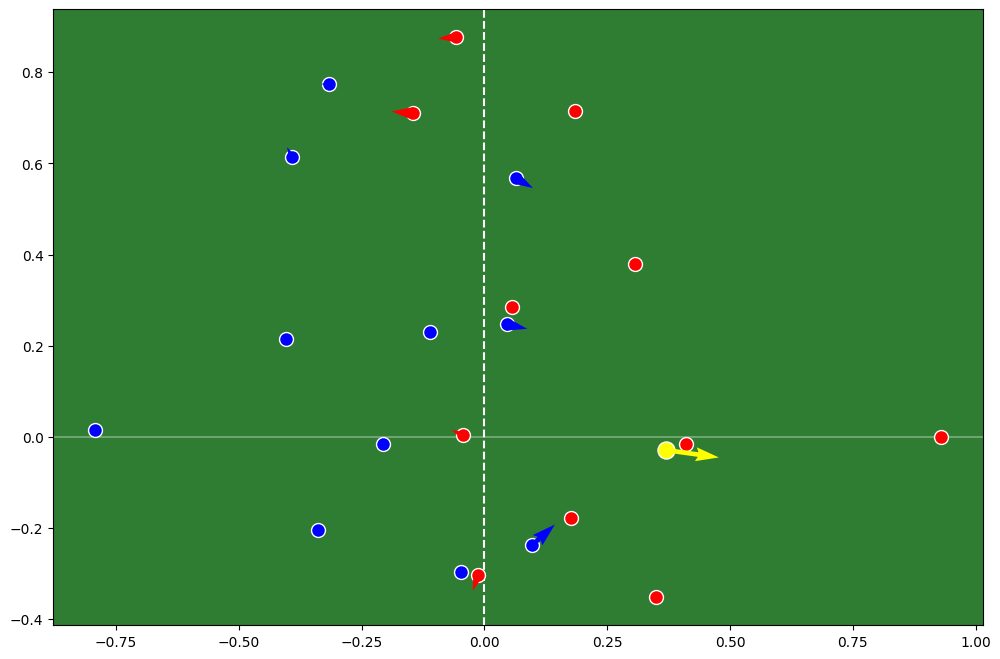

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_4.pt"
visualize_processed_scene(path, scene_idx=1)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 6
SET_MANUAL_FLIP = -1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "00000P"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 7: DFL-MAT-J03WR9 =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 432 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_7.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_7.pt ---
検証シーン数 (y=1): 32
  [1] ボールの右向き推進率: 87.5%
      -> ✅ 物理強制成功
  [2] 全選手の右向き率:     80.8%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

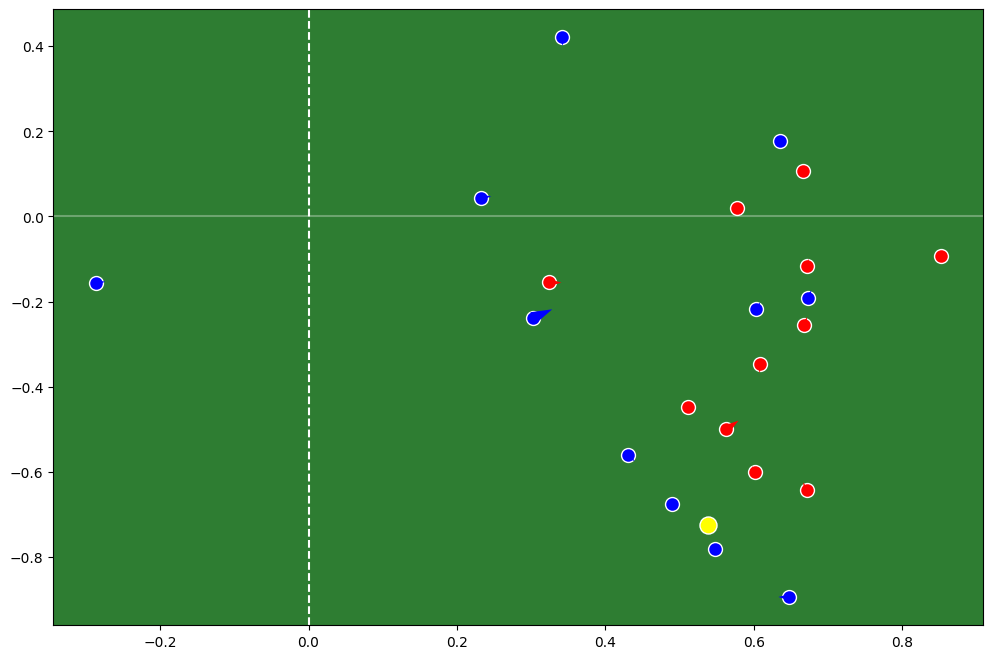

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_7.pt"
visualize_processed_scene(path, scene_idx=28)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 5
SET_MANUAL_FLIP = 1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "00000H"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 6: DFL-MAT-J03WQQ =====
-> ✅ 成功: 488 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_6.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_6.pt ---
検証シーン数 (y=1): 36
  [1] ボールの右向き推進率: 83.3%
      -> ✅ 物理強制成功
  [2] 全選手の右向き率:     87.7%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

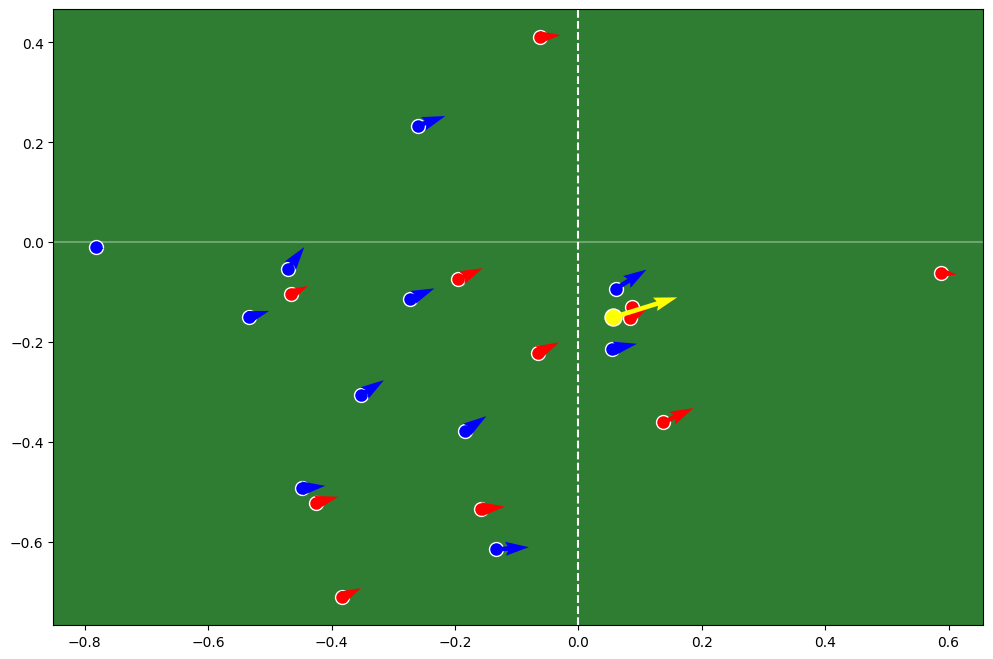

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_6.pt"
visualize_processed_scene(path, scene_idx=20)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 4
SET_MANUAL_FLIP = -1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "000005"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 5: DFL-MAT-J03WPY =====
-> ✅ 成功: 442 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_5.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_5.pt ---
検証シーン数 (y=1): 34
  [1] ボールの右向き推進率: 88.2%
      -> ✅ 物理強制成功
  [2] 全選手の右向き率:     80.4%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

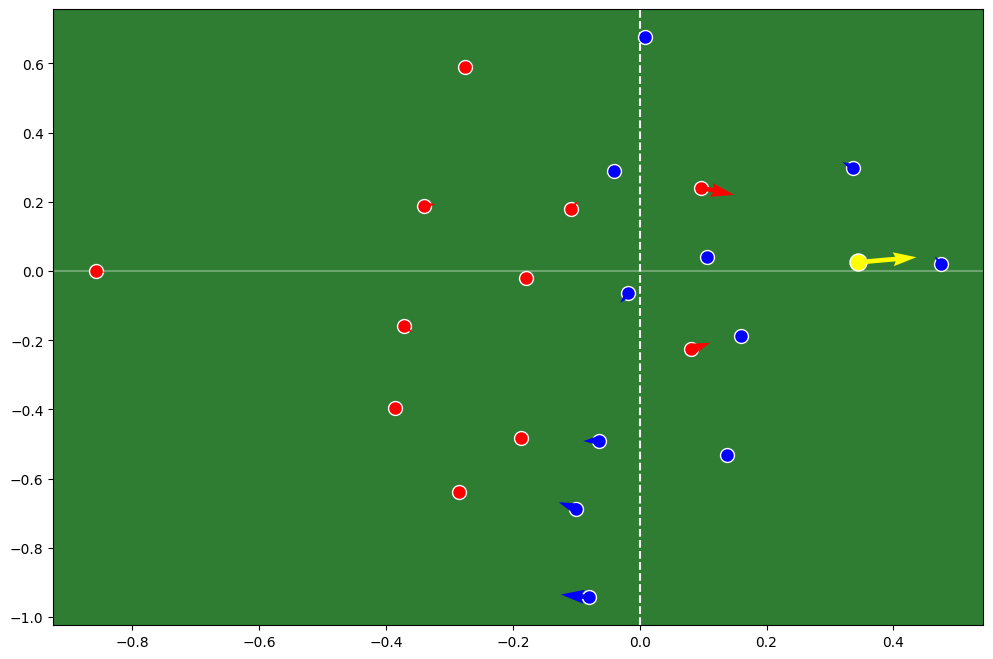

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_5.pt"
visualize_processed_scene(path, scene_idx=4)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 2
SET_MANUAL_FLIP = 1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "000011"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 3: DFL-MAT-J03WOH =====
-> ✅ 成功: 492 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_3.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_3.pt ---
検証シーン数 (y=1): 20
  [1] ボールの右向き推進率: 80.0%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     87.6%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

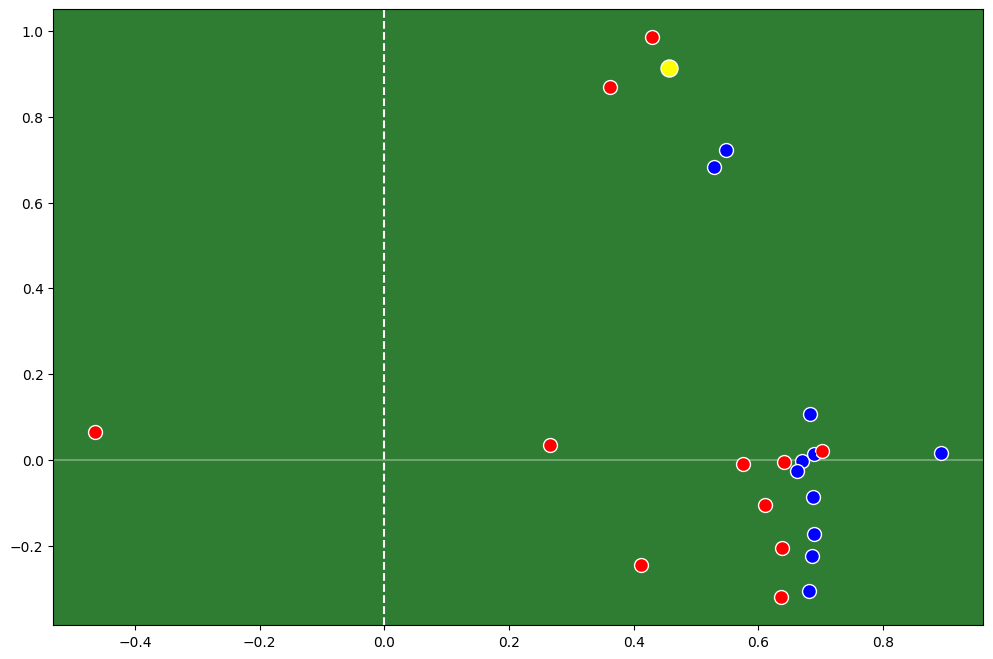

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_3.pt"
visualize_processed_scene(path, scene_idx=470)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 1
SET_MANUAL_FLIP = 1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "00000B"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 2: DFL-MAT-J03WN1 =====
-> ✅ 成功: 434 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_2.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_2.pt ---
検証シーン数 (y=1): 30
  [1] ボールの右向き推進率: 86.7%
      -> ✅ 物理強制成功
  [2] 全選手の右向き率:     78.9%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

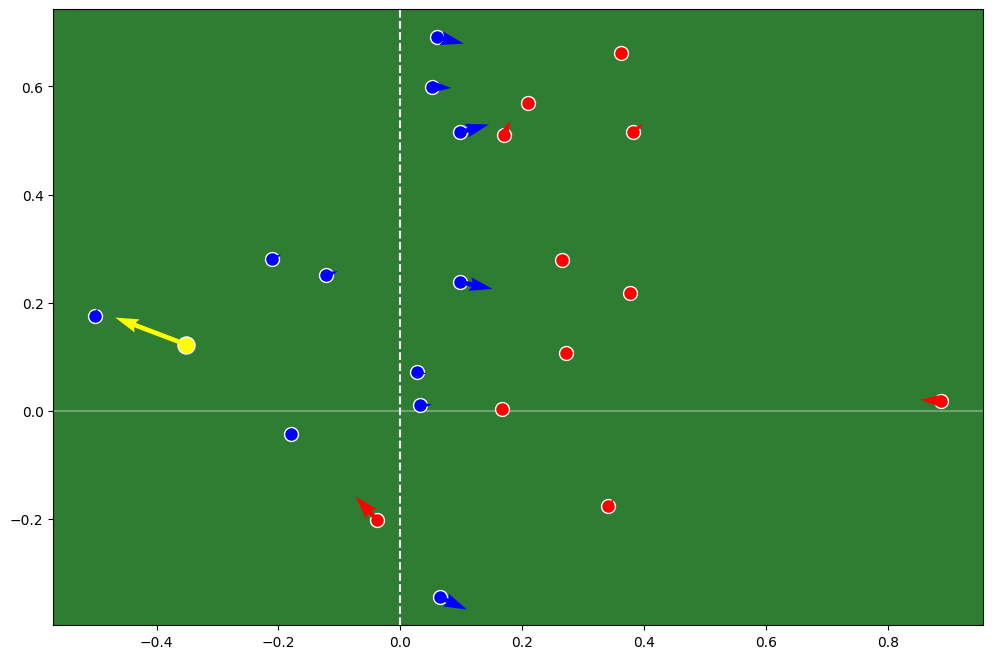

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_2.pt"
visualize_processed_scene(path, scene_idx=90)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 【確定設定】Match 4 救済設定 ---
TARGET_MATCH_IDX = 0
SET_MANUAL_FLIP = 1.0 # ボール推進率を改善するために反転
SET_LEFT_TEAM = "00000G"

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました。")
    else:
        print("-> ⚠ 成功シーンが0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 1: DFL-MAT-J03WMX =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 518 シーンを保存しました。


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 80 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_1.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_1.pt ---
検証シーン数 (y=1): 82
  [1] ボールの右向き推進率: 36.6%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     63.7%
      -> ⚠ 異常値 (再確認が必要)


ValueError: Unrecognized marker style '['

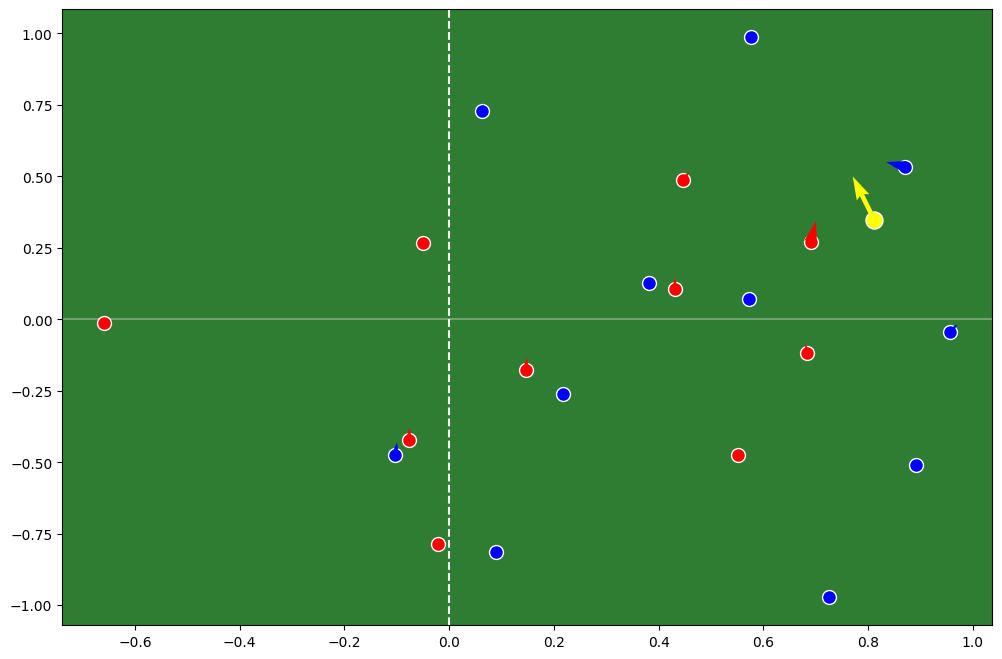

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15/match_1.pt"
visualize_processed_scene(path, scene_idx=300)

クロスバリデーションのために、そのまま保存

In [ ]:
import os
import torch
from collections import Counter

# ==========================================
# セクション2: データのロード（match_idを明示的に付与）
# ==========================================
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v15"
final_output_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v16_final.pt"

match_files = sorted([os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.startswith('match_') and f.endswith('.pt')])
all_data = []

print(f"{len(match_files)} 試合分の統合開始...")

for i, f in enumerate(match_files):
    # ファイル名に関わらず、1から始まる連番を試合IDとして確定させる
    current_match_id = i + 1

    m_data = torch.load(f, weights_only=False)

    # 【ここが重要！】
    # 各データオブジェクトに match_id 属性を追加する
    for d in m_data:
        d.match_id = torch.tensor([current_match_id])

    all_data.extend(m_data)
    print(f" -> {os.path.basename(f)}: {len(m_data)} frames loaded. (Marked as Match {current_match_id})")

# ==========================================
# セクション3: 保存
# ==========================================
print(f"\n--- 最終データ構成（CV用・ID刻印済み） ---")
print(f"総フレーム数: {len(all_data)}")

all_lbls = Counter([int(d.y.item()) for d in all_data])
print(f"全データ内訳: 成功 {all_lbls[1]} 枚 / 失敗 {all_lbls[0]} 枚")

# 試合ごとの内訳も確認（デバッグ用）
match_counts = Counter([int(d.match_id.item()) for d in all_data])
print(f"試合別フレーム数: {dict(sorted(match_counts.items()))}")

save_obj = {
    'all_data': all_data,
    'description': 'v16 integrated data with explicit match_id'
}

torch.save(save_obj, final_output_path)
print(f"\n✅ 保存完了: {final_output_path}")

7 試合分の統合開始...
 -> match_1.pt: 518 frames loaded. (Marked as Match 1)
 -> match_2.pt: 434 frames loaded. (Marked as Match 2)
 -> match_3.pt: 492 frames loaded. (Marked as Match 3)
 -> match_4.pt: 438 frames loaded. (Marked as Match 4)
 -> match_5.pt: 442 frames loaded. (Marked as Match 5)
 -> match_6.pt: 488 frames loaded. (Marked as Match 6)
 -> match_7.pt: 432 frames loaded. (Marked as Match 7)

--- 最終データ構成（CV用・ID刻印済み） ---
総フレーム数: 3244
全データ内訳: 成功 264 枚 / 失敗 2980 枚
試合別フレーム数: {1: 518, 2: 434, 3: 492, 4: 438, 5: 442, 6: 488, 7: 432}

✅ 保存完了: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v16_final.pt
